In [5]:
from datasets import load_dataset

In [6]:
import pandas as pd

In [7]:
sst2 = load_dataset('sst2')

In [8]:
affixal_df = pd.read_csv('tokenized_data.csv')

In [9]:
affixal_df.head()

,Unnamed: 0,neg_word,pos_word,hyphen_word,negative_affix,tokenizer,neg_bytes,neg_correct,soft_neg_correct,pos_bytes,pos_correct,soft_pos_correct,hyphen_bytes,hyphen_correct,soft_hyphen_correct,tokenizer_type
0,0,abducent,adducent,ab-ducent,ab,gpt2,"['ab', 'du', 'cent']",Correct,Correct,"['ad', 'du', 'cent']",Incorrect,Incorrect,"['ab', '-', 'du', 'cent']",Correct,Correct,byte_level_bpe
1,1,abducent,adducent,ab-ducent,ab,p50k_base,"['ab', 'du', 'cent']",Correct,Correct,"['ad', 'du', 'cent']",Incorrect,Incorrect,"['ab', '-', 'du', 'cent']",Correct,Correct,byte_level_bpe
2,2,abducent,adducent,ab-ducent,ab,cl100k_base,"['ab', 'du', 'cent']",Correct,Correct,"['add', 'u', 'cent']",Incorrect,Incorrect,"['ab', '-du', 'cent']",Correct,Correct,byte_level_bpe
3,3,abducent,adducent,ab-ducent,ab,roberta-base,"['ab', 'du', 'cent']",Correct,Correct,"['ad', 'du', 'cent']",Incorrect,Incorrect,"['ab', '-', 'du', 'cent']",Correct,Correct,byte_level_bpe
4,4,abducent,adducent,ab-ducent,ab,xlnet-base-cased,"['ab', 'du', 'cent']",Correct,Correct,"['add', 'u', 'cent']",Incorrect,Incorrect,"['ab', '-', 'du', 'cent']",Correct,Correct,sentencepiece


In [12]:
negation_words = list(set(affixal_df['neg_word']))

In [13]:
sst2['train']['sentence'][0]

'hide new secretions from the parental units '

In [14]:
from flashtext import KeywordProcessor

In [15]:
keyword_processor = KeywordProcessor()
for word in negation_words:
    keyword_processor.add_keyword(word)

In [16]:
def extract_samples_with_neg_affix(sentences):
    negative_affixes_idx = []
    for i,sentence in enumerate(sentences):
        keywords_found = keyword_processor.extract_keywords(sentence)
        if len(keywords_found) > 0:
            negative_affixes_idx.append(i)
    # small_set = dataset.select(negative_affixes_idx)
    return negative_affixes_idx

In [17]:
sst2_test_affixes_samples = sst2['validation'].select(extract_samples_with_neg_affix(sst2['validation']['sentence']))

In [21]:
# Twitter
twitter = load_dataset("tweet_eval", "sentiment")

In [22]:
twitter_test_affixes_samples = twitter['test'].select(extract_samples_with_neg_affix(twitter['test']['text']))

In [23]:
len(twitter_test_affixes_samples)

387

In [24]:
rt = load_dataset('rotten_tomatoes')

In [25]:
rt_test_affixes_samples = rt['test'].select(extract_samples_with_neg_affix(rt['test']['text']))

In [26]:
len(rt_test_affixes_samples)

103

In [27]:
amazon = load_dataset('amazon_polarity')

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [32]:
amazon['test']

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 400000
})

In [33]:
amazon_test_affixes_samples = amazon['test'].select(extract_samples_with_neg_affix(amazon['test']['content']))

In [34]:
amazon_test_affixes_samples

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 7148
})

In [35]:
amazon_test_affixes_samples = amazon_test_affixes_samples.remove_columns(['content'])

In [37]:
amazon_test_affixes_samples = amazon_test_affixes_samples.rename_column('title','text')

In [38]:
amazon_test_affixes_samples

Dataset({
    features: ['label', 'text'],
    num_rows: 7148
})

In [39]:
from datasets import concatenate_datasets

In [48]:
from datasets import ClassLabel

In [45]:
features = amazon_test_affixes_samples.features.copy()

In [46]:
features

{'label': ClassLabel(names=['negative', 'positive'], id=None),
 'text': Value(dtype='string', id=None)}

In [49]:
features["label"] = ClassLabel(names=["neg", "pos"])

In [50]:
amazon_test_affixes_samples = amazon_test_affixes_samples.cast(features)

Casting the dataset:   0%|          | 0/7148 [00:00<?, ? examples/s]

In [54]:
sst2_test_affixes_samples = sst2_test_affixes_samples.remove_columns(['idx'])

In [55]:
sst2_test_affixes_samples=sst2_test_affixes_samples.rename_column('sentence','text')

In [56]:
sst2_test_affixes_samples = sst2_test_affixes_samples.cast(features)

Casting the dataset:   0%|          | 0/67 [00:00<?, ? examples/s]

In [57]:
affix_ds = concatenate_datasets([amazon_test_affixes_samples,rt_test_affixes_samples,sst2_test_affixes_samples])

In [59]:
affix_ds = affix_ds.shuffle(seed=42)

In [60]:
affix_ds.push_to_hub('joey234/sentiment_analysis_affix')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

In [62]:
affix_ds['text'][0]

'Incorrect Product info.'

In [63]:
ds = load_dataset('joey234/sentiment_analysis_affix')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7318 [00:00<?, ? examples/s]

In [64]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 7318
    })
})

In [69]:
ds = concatenate_datasets([sst2_test_affixes_samples,rt_test_affixes_samples])

In [71]:
ds.push_to_hub('joey234/sentiment_analysis_affix_small')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [66]:
imdb = load_dataset('imdb')
imdb_test_affixes_samples = imdb['test'].select(extract_samples_with_neg_affix(imdb['test']['text']))

In [67]:
imdb_test_affixes_samples

Dataset({
    features: ['text', 'label'],
    num_rows: 10633
})

In [26]:
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset


In [ ]:
pipe = pipeline("text-classification", model = 'siebert/sentiment-roberta-large-english', tokenizer = 'siebert/sentiment-roberta-large-english')


In [49]:
rt_out = []
for out in pipe(KeyDataset(rt_test_affixes_samples, "text"), batch_size=8, truncation="only_first"):
    rt_out.append(out)

In [32]:
label_map = {'POSITIVE':1, 'NEGATIVE':0}

In [50]:
for i, out in enumerate(rt_out):
    pred = label_map[out['label']]
    gold = rt_test_affixes_samples['label'][i]
    if pred != gold:
        print(rt_test_affixes_samples['text'][i], pred, gold)

meant to reduce blake's philosophy into a tragic coming-of-age saga punctuated by bursts of animator todd mcfarlane's superhero dystopia . 0 1
a movie where story is almost an afterthought amidst a swirl of colors and inexplicable events . 0 1
often demented in a good way , but it is an uneven film for the most part . 0 1
the beautiful , unusual music is this film's chief draw , but its dreaminess may lull you to sleep . 1 0
the punch lines that miss , unfortunately , outnumber the hits by three-to-one . but death to smoochy keeps firing until the bitter end . 1 0
those eternally devoted to the insanity of black will have an intermittently good time . feel free to go get popcorn whenever he's not onscreen . 1 0
proves a lovely trifle that , unfortunately , is a little too in love with its own cuteness . 1 0


In [46]:
sst2_out = []
for out in pipe(KeyDataset(sst2_test_affixes_samples, "sentence"), batch_size=8, truncation="only_first"):
    sst2_out.append(out)

In [41]:
sst2_out[0]

{'label': 'NEGATIVE', 'score': 0.9994656443595886}

In [47]:
for i, out in enumerate(sst2_out):
    pred = label_map[out['label']]
    gold = sst2_test_affixes_samples['label'][i]
    if pred != gold:
        print(sst2_test_affixes_samples['sentence'][i], pred, gold)

to call the other side of heaven `` appalling '' would be to underestimate just how dangerous entertainments like it can be .  1 0
trite , banal , cliched , mostly inoffensive .  1 0
on the heels of the ring comes a similarly morose and humorless horror movie that , although flawed , is to be commended for its straight-ahead approach to creepiness .  0 1
... routine , harmless diversion and little else .  0 1


In [52]:
pipe_3class = pipeline("sentiment-analysis", model = 'cardiffnlp/twitter-roberta-base-sentiment-latest', tokenizer = 'cardiffnlp/twitter-roberta-base-sentiment-latest')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
label_map_3 = {'NEUTRAL':1, 'NEGATIVE':0, 'POSITIVE':2}

In [55]:
twitter_out = []
for out in pipe(KeyDataset(twitter_test_affixes_samples, "text"), batch_size=8, truncation="only_first"):
    twitter_out.append(out)

In [58]:
for i, out in enumerate(twitter_out):
    pred = label_map_3[out['label']]
    gold = twitter_test_affixes_samples['label'][i]
    if pred != gold:
        print(twitter_test_affixes_samples['text'][i], pred, gold)

@user @user involuntary euthanasia is a better system 0 1
Power of 50+ years of unrelenting CIA propaganda for sure. Lest we also forget 50+ years illegal USA trade embargo… 0 1
Michael Hicks picks off Bishop Moore pass; after illegal-block penalty @user ball at its 33 7:50 2Q @user @user 0 1
#Russia-n and Chinese Defense Ministers discuss the latest development in #Libya, on the margin of a joint military… 2 1
True, the Obama Admin. Squashed the Tea Party movement, unprecedented behavior. 0 1
The defense of the US elections from the Obama Admin came amidst hacking fears & allegations of hacking from Russi… 2 1
@user  Trump always appeared uncomfortable with chants of #LockHerUp and #DrainTheSwamp 0 1
The Truth, The Whole Truth & Nothing But The Truth! These voter registration laws SHOULD B UNCONSTITUTIONAL  bc the… 0 1
Consumer Reports: Tesla's Model X Is 'Fast and Flawed' - An anonymous reader quotes a report from MarketWatch: ... 0 1
Expectations Are High For Trump’s Moves On Aborti

In [4]:
import openai
import os

In [5]:
from tenacity import retry, stop_after_attempt, wait_chain, wait_fixed


In [7]:
MODEL = "gpt-4"

In [8]:
@retry(wait=wait_chain(*[wait_fixed(3) for i in range(3)] +
                       [wait_fixed(5) for i in range(2)] +
                       [wait_fixed(10)]))
def completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

In [11]:
def format_prompt(word, options):
    instruction = f'The word "{word}" contains negation. {options}?\nAnswer:'
    messages = [
        {"role": "system", "content": 'Be precise and only answer with the given options.'},
        {"role": "user", "content": instruction.format(word, options)},
    ]
    return messages

In [12]:
def request(samples, options):
    ret = []
    for sample in samples:
        messages = format_prompt(sample, options)
        response = completion_with_backoff(
            model=MODEL,
            messages= messages,
            temperature=0,
        )
        # print(messages)
        ans_model = response['choices'][0]['message']['content']
        print(sample, ans_model)
        ret.append([sample, ans_model])
        # print(ans_model)
        # print('===================')
    return ret

In [17]:
negation_words = sorted(list(set(negation_words)))

In [18]:
ret = request(negation_words, 'True or False')

Nonconformist True
abactinal True
abducent False
abnormal True
abnormality False
aborad False
aboral True
abranchiate True
acarpelous True
acatalectic True
acaulescent True
achondritic False
achromatic True
achromatic_color False
achromatinic False
acyclic True
adiabatic False
agnostic True
ahistorical True
analphabetic True
anaphrodisia True
anastigmatic False
anestrous True
anhydrous True
anisotropic False
anonymous False
anovulation True
anticatalyst True
anticholinergic False
anticlimactic True
anticlinal False
antimagnetic True
antinode False
antipyretic False
antiseptic False
antitype True
aperiodic True
apetalous True
aplacental True
armless True
artless True
artlessness True
asexual False
astigmatism False
astomatous True
asymmetrical True
asymmetrically False
asymmetry True
asynchronism True
asynchronous True
asyndetic True
atomistic False
atonal True
atonality True
atonic True
atonicity False
atypical True
atypicality True
atypically True
avascular True
avirulent True
awnless

In [19]:
ret = dict(ret)

In [20]:
ret

{'Nonconformist': 'True',
 'abactinal': 'True',
 'abducent': 'False',
 'abnormal': 'True',
 'abnormality': 'False',
 'aborad': 'False',
 'aboral': 'True',
 'abranchiate': 'True',
 'acarpelous': 'True',
 'acatalectic': 'True',
 'acaulescent': 'True',
 'achondritic': 'False',
 'achromatic': 'True',
 'achromatic_color': 'False',
 'achromatinic': 'False',
 'acyclic': 'True',
 'adiabatic': 'False',
 'agnostic': 'True',
 'ahistorical': 'True',
 'analphabetic': 'True',
 'anaphrodisia': 'True',
 'anastigmatic': 'False',
 'anestrous': 'True',
 'anhydrous': 'True',
 'anisotropic': 'False',
 'anonymous': 'False',
 'anovulation': 'True',
 'anticatalyst': 'True',
 'anticholinergic': 'False',
 'anticlimactic': 'True',
 'anticlinal': 'False',
 'antimagnetic': 'True',
 'antinode': 'False',
 'antipyretic': 'False',
 'antiseptic': 'False',
 'antitype': 'True',
 'aperiodic': 'True',
 'apetalous': 'True',
 'aplacental': 'True',
 'armless': 'True',
 'artless': 'True',
 'artlessness': 'True',
 'asexual': 'F

In [21]:
gpt4_df = affixal_df[affixal_df['tokenizer']=='cl100k_base']

In [22]:
gpt4_df

,Unnamed: 0,word,negative_affix,tokenizer,bytes,correct,tokenizer_type
2,2,abducent,ab,cl100k_base,"['ab', 'du', 'cent']",Correct,byte_level_bpe
12,12,unable,un,cl100k_base,['unable'],Not segmented,byte_level_bpe
22,22,unabridged,un,cl100k_base,"['un', 'ab', 'ridged']",Correct,byte_level_bpe
32,32,nonabsorbent,non,cl100k_base,"['non', 'abs', 'orb', 'ent']",Correct,byte_level_bpe
42,42,unabused,un,cl100k_base,"['un', 'ab', 'used']",Correct,byte_level_bpe
...,...,...,...,...,...,...,...
20932,20932,unweave,un,cl100k_base,"['un', 'we', 'ave']",Correct,byte_level_bpe
20942,20942,unwind,un,cl100k_base,"['un', 'wind']",Correct,byte_level_bpe
20952,20952,unwire,un,cl100k_base,"['un', 'wire']",Correct,byte_level_bpe
20962,20962,unwrap,un,cl100k_base,['unwrap'],Not segmented,byte_level_bpe


In [23]:
rows = []
for i,row in gpt4_df.iterrows():
    row['Negated'] = ret[row['word']]
    rows.append(row)

In [24]:
gpt4_df = pd.DataFrame(data = rows)

In [25]:
gpt4_df.to_csv('gpt4_quote_results.csv', index = None)

In [30]:
gpt4_df = pd.read_csv('gpt4_results.csv')

In [31]:
gpt4_df['Negated'].value_counts()

Negated
True     1682
False     416
Name: count, dtype: int64

In [10]:
import pandas as pd

In [11]:
gpt4_quote_df = pd.read_csv('gpt4_quote_results.csv')

In [12]:
gpt4_quote_df['Negated'].value_counts()

Negated
True     1658
False     440
Name: count, dtype: int64

In [33]:
len(gpt4_df)

2098

In [13]:
1658/(1682+416)

0.7902764537654909

In [53]:
gpt4_df[gpt4_df['word'] == 'inconclusive']

,Unnamed: 0,word,negative_affix,tokenizer,bytes,correct,tokenizer_type,Negated
229,2292,inconclusive,in,cl100k_base,"['in', 'con', 'clusive']",Correct,byte_level_bpe,True


In [194]:
gpt4_df[gpt4_df['correct']=='Correct']['Negated'].value_counts()

Negated
True     1184
False     216
Name: count, dtype: int64

In [195]:
gpt4_df[gpt4_df['correct']=='Incorrect']['Negated'].value_counts()

Negated
True     478
False    184
Name: count, dtype: int64

In [196]:
gpt4_df[gpt4_df['correct']=='Not segmented']['Negated'].value_counts()

Negated
True     20
False    16
Name: count, dtype: int64

In [197]:
error = gpt4_df.loc[(gpt4_df['correct']!='Correct') & (gpt4_df['Negated']=='False')]

In [198]:
error

,Unnamed: 0,word,negative_affix,tokenizer,bytes,correct,tokenizer_type,Negated
102,102,discordant,dis,cl100k_base,"['discord', 'ant']",Incorrect,byte_level_bpe,False
552,552,anastigmatic,un,cl100k_base,"['an', 'ast', 'igmatic']",Incorrect,byte_level_bpe,False
592,592,anonymous,ab,cl100k_base,['anonymous'],Not segmented,byte_level_bpe,False
602,602,anticlinal,anti,cl100k_base,"['antic', 'l', 'inal']",Incorrect,byte_level_bpe,False
802,802,descending,de,cl100k_base,['descending'],Not segmented,byte_level_bpe,False
...,...,...,...,...,...,...,...,...
20642,20642,desensitize,de,cl100k_base,"['des', 'ens', 'itize']",Incorrect,byte_level_bpe,False
20702,20702,destalinize,de,cl100k_base,"['dest', 'alin', 'ize']",Incorrect,byte_level_bpe,False
20782,20782,detransitivize,de,cl100k_base,"['d', 'etr', 'ans', 'it', 'iv', 'ize']",Incorrect,byte_level_bpe,False
20812,20812,untwine,un,cl100k_base,"['unt', 'wine']",Incorrect,byte_level_bpe,False


In [6]:
error.to_csv('gpt4_error.csv', index = None)

NameError: name 'error' is not defined

In [13]:
gpt4_df = pd.read_csv('gpt4_pred.csv')

In [14]:
gpt4_df

,word,pred,gold
0,premeditated,1,1
1,inspan,1,1
2,disarrange,0,0
3,restrictive,1,1
4,illiterate,0,0
...,...,...,...
4160,detected,1,1
4161,ingenuousness,1,1
4162,deoxidise,0,0
4163,gracefully,1,1


In [12]:
# Calculate the total count for each 'tokenizer_type'                                                                                                     
total_count = gpt4_df['correct'].value_counts()                                                                                                         
                                                                                                                                                        
# Calculate the count for each 'tokenizer_type' and 'correct' combination                                                                                 
correct_count = gpt4_df[gpt4_df['Negated'] == 'True']['correct'].value_counts()                                                                                
incorrect_count = gpt4_df[gpt4_df['Negated'] == 'False']['correct'].value_counts()                                                                             
                                                                                                     
# Calculate the percentage                                                                                                                                
percentage_correct = correct_count / total_count * 100                                                                                                    
percentage_incorrect = incorrect_count / total_count * 100                                                                                                
                                                                                                                                                        
percentage_correct, percentage_incorrect

(correct
 Incorrect       NaN
 Not segmented   NaN
 Name: count, dtype: float64,
 correct
 Incorrect       NaN
 Not segmented   NaN
 Name: count, dtype: float64)

In [9]:
import matplotlib.pyplot as plt                                                                                                                           
import seaborn as sns                                                                                                                                     


In [4]:
percentage_df = pd.DataFrame({'True': percentage_correct, 'False': percentage_incorrect})                                              
                                                                                                                                                        
# Plot the DataFrame                                                                                                                                      
percentage_df.plot(kind='bar', stacked=True)                                                                                                              
                                                                                                                                                        
# plt.title('Percentage of Correct/Not Correct/Not Segmented for Each Tokenizer Type')                                                                                    
plt.xlabel('Morphology')                                                                                                                              
plt.ylabel('Percentage')                                                                                                                                  
plt.show()                                                                                                                                                


NameError: name 'percentage_correct' is not defined

In [208]:
gpt4_df[gpt4_df['Negated'] == True]

,Unnamed: 0,word,negative_affix,tokenizer,bytes,correct,tokenizer_type,Negated


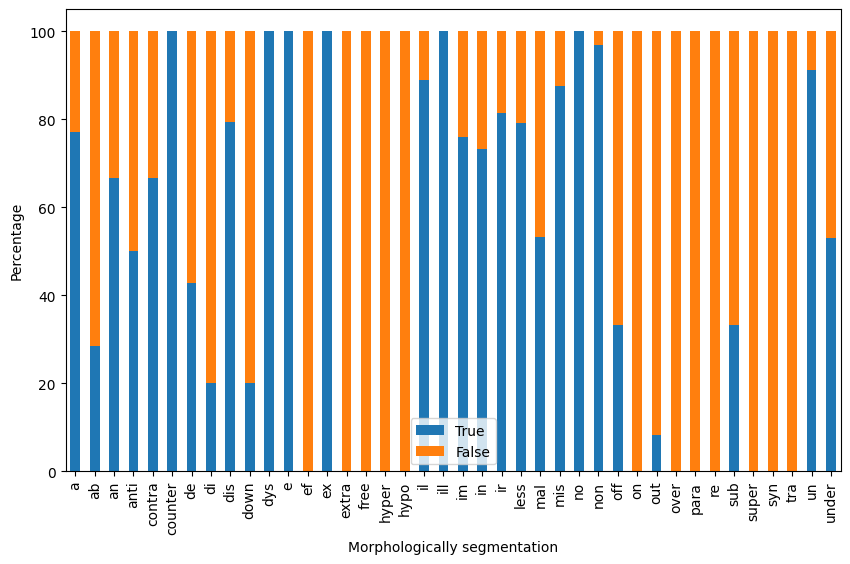

In [209]:
# Calculate the total count for each 'negative_affix'                                                                                                     
total_count = gpt4_df['negative_affix'].value_counts()                                                                                                         
                                                                                                                                                        
# Calculate the count for each 'negative_affix' and 'correct' combination                                                                                 
correct_count = gpt4_df[gpt4_df['Negated'] == "True"]['negative_affix'].value_counts()                                                                                
incorrect_count = gpt4_df[gpt4_df['Negated'] == "False"]['negative_affix'].value_counts()                                                                             
# not_segmented_count = df[df['correct'] == 'Not segmented']['negative_affix'].value_counts()                                                                             
                                                                                                                                                        
# Calculate the percentage                                                                                                                                
percentage_correct = correct_count / total_count * 100                                                                                                    
percentage_incorrect = incorrect_count / total_count * 100   
# percentage_not_segmented = not_segmented_count / total_count * 100                                                                                                
# 
                                                                                                                                                        
# Create a DataFrame from the percentage data                                                                                                             
percentage_df = pd.DataFrame({'True': percentage_correct, 'False': percentage_incorrect})                                                        
                                                                                                                                                        
# Plot the DataFrame

plt.rcParams['figure.figsize'] = [10, 6]
percentage_df.plot(kind='bar', stacked=True)                                                                                                              
# plt.title('Percentage of Correct/Not Correct/Not Segmented for Each Negative Affix')                                                                                    
plt.xlabel('Morphologically segmentation')                                                                                                                              
plt.ylabel('Percentage')                                                                                                                                  
plt.show()                                                                                                                                                

In [1]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

In [2]:
from transformers import AutoTokenizer, AutoModel, utils
utils.logging.set_verbosity_error()  # Suppress standard warnings


In [4]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf")
model = AutoModel.from_pretrained("meta-llama/Llama-2-13b-chat-hf", output_attentions=True)
sample_prompt = '''The word un-vibble contains negation. True or False?
Answer:'''
inputs = tokenizer.encode(sample_prompt, return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
from bertviz import head_view, model_view
head_view(attention, tokens)


ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.

In [8]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2", output_attentions=True)
sample_prompt = '''The word dis-agreeable contains negation. True or False?
Answer:'''
inputs = tokenizer.encode(sample_prompt, return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
from bertviz import head_view, model_view
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2", output_attentions=True)
sample_prompt = '''The word meek contains negation. True or False?
Answer:'''
inputs = tokenizer.encode(sample_prompt, return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
from bertviz import head_view, model_view
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [1]:
import inseq


In [25]:
model = inseq.load_model("google/flan-t5-base", "sequential_integrated_gradients")


In [29]:
model = inseq.load_model("google/flan-t5-base", "integrated_gradients")

# Uses Huggingface generate method + automatically decodes outputs
natural_generation = model.generate("The sentiment of the word dissent is positive, negative, or neutral?\nAnswer:", max_new_tokens=4)[0]

print("Natural output:", natural_generation)

# Why "he" rather than "she"?
out = model.attribute(
    input_texts=["The sentiment of the word dissent is positive, negative, or neutral?\nAnswer:", "The sentiment of the word dissent is positive, negative, or neutral?\nAnswer:"],
    # generated_texts is used to force the attribution of the specified texts
    generated_texts=[" negative", " positive"],
    step_scores=["probability"],
)

out.show()


Natural output: negative




Attributing with integrated_gradients...:  33%|█████████████████████████████████████████████████                                                                                                  | 1/3 [00:00<?, ?it/s]

Attributing with integrated_gradients...:  67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2/3 [00:01<00:01,  1.99s/it]

Attributing with integrated_gradients...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.77s/it]


,▁negative,</s>
▁The,0.034,0.063
▁sentiment,0.092,0.129
▁of,0.03,0.049
▁the,0.03,0.084
▁word,0.054,0.05
▁,0.042,0.022
d,0.041,0.015
issent,0.251,0.064
▁is,0.034,0.024
▁positive,0.042,0.032


,▁positive,</s>
▁The,0.028,0.084
▁sentiment,0.064,0.09
▁of,0.032,0.039
▁the,0.051,0.04
▁word,0.054,0.037
▁,0.04,0.024
d,0.046,0.015
issent,0.296,0.053
▁is,0.034,0.023
▁positive,0.048,0.029


In [27]:
attribution_model = inseq.load_model("google/flan-t5-base", "saliency")

# Perform the contrastive attribution:
# Regular (forced) target -> "Ho salutato il manager"
# Contrastive target      -> "Ho salutato la manager"
out = attribution_model.attribute(
    "The sentiment of the word dissent is positive, negative, or neutral?\nAnswer:",
    " negative",
    attributed_fn="contrast_prob_diff",
    # Special argument to specify the contrastive target, used by the contrast_prob_diff function
    contrast_targets=" positive",
    attribute_target=True,
    # We also visualize the score used as target using the same function as step score
    step_scores=["contrast_prob_diff"],
)

# Weight attribution scores by the difference in probabilities
out.weight_attributions("contrast_prob_diff")
out.show()


Provided alignments do not cover all 2 tokens from the original sequence.
Filling missing position with right-aligned 1:1 position alignments.
Generated alignments: [(2, 2), (1, 1)]


Attributing with saliency...:  33%|█████████████████████████████████████████████████████                                                                                                          | 1/3 [00:00<?, ?it/s]/Users/thinhtruong/miniconda3/lib/python3.10/site-packages/inseq/utils/contrast_utils.py:146: UserWarning: Contrastive inputs do not match original inputs when using a contrastive attributed function.
By default we force the original inputs to be used (i.e. only the contrastive predicted target is different).
This is a requirement for gradient-based attribution method, as contrastive inputs don't participate in gradient computation.
For attribution methods with less stringent requirements, set --contrast_force_inputs to True to use the contrastive inputs for attribution instead.
  warnings.war

,▁positive → ▁negative,</s>
▁The,0.043,-0.0
▁sentiment,0.049,-0.0
▁of,0.035,-0.0
▁the,0.027,-0.0
▁word,0.043,-0.0
▁,0.037,-0.0
d,0.046,-0.0
issent,0.097,-0.0
▁is,0.032,-0.0
▁positive,0.027,-0.0


In [26]:
text= '''The sentiment of the word undrinkable is positive, negative, or neutral?
Answer:'''
model.attribute(
    text,
    attribute_target = True
).show()


Attributing with sequential_integrated_gradients...:  33%|█████████████████████████████████████████████▎                                                                                          | 1/3 [00:00<?, ?it/s]

AssertionError: All inputs must have the same sequential dimension. (dimension 1)

In [20]:
text_neutral= '''The sentiment of the word dissent is positive, negative, or neutral?
Answer:'''
model.attribute(
    text_neutral,
    attribute_target = True
).show()


Attributing with integrated_gradients...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.03it/s]


,▁negative,</s>
▁The,0.034,0.063
▁sentiment,0.097,0.105
▁of,0.03,0.044
▁the,0.025,0.037
▁word,0.05,0.041
▁un,0.106,0.03
in,0.08,0.024
form,0.137,0.038
▁is,0.032,0.026
▁positive,0.044,0.04



Attributing with integrated_gradients...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.05it/s]


,▁negative,</s>
▁The,0.033,0.06
▁sentiment,0.081,0.095
▁of,0.03,0.047
▁the,0.036,0.039
▁word,0.06,0.039
▁un,0.123,0.033
treated,0.204,0.057
▁is,0.043,0.026
▁positive,0.043,0.04
",",0.026,0.045


In [ ]:
prompt = "The Eiffel Tower is located in the city of"
true_answer = "The Eiffel Tower is located in the city of Paris"
false_answer = "The Eiffel Tower is located in the city of Rome"

